In [1]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt

# Import from your custom .py files
# We need to add the script directory to our path
import sys
sys.path.append('SegmentationUNet')

from datasets import get_images, get_dataset, get_data_loaders, get_test_images, get_test_loader
from engine import train, validate
from model import UNet
from config import ALL_CLASSES, LABEL_COLORS_LIST
from utils import save_model, SaveBestModel, save_plots, SaveBestModelIOU, image_overlay, draw_segmentation_map, get_segment_labels
from torch.optim.lr_scheduler import MultiStepLR
from metrics import IOUEval
import cv2
from tqdm.notebook import tqdm # Use notebook-friendly tqdm
import numpy as np

In [2]:
# -- Settings --
DATA_PATH = 'segmentation dataset/segmentation dataset'
OUTPUT_PATH = 'outputs'
EPOCHS = 50
LEARNING_RATE = 0.003
BATCH_SIZE = 4
IMG_SIZE = 256

# Create output directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'valid_preds'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'inference_results'), exist_ok=True)

# Setup device
# New line
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:3


In [3]:
train_images, train_masks, valid_images, valid_masks = get_images(root_path=DATA_PATH)
train_dataset, valid_dataset = get_dataset(
    train_images, train_masks,
    valid_images, valid_masks,
    ALL_CLASSES, ALL_CLASSES,
    LABEL_COLORS_LIST,
    img_size=IMG_SIZE
)
train_dataloader, valid_dataloader = get_data_loaders(
    train_dataset, valid_dataset, batch_size=BATCH_SIZE
)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")

Training samples: 8668, Validation samples: 895


/root/Group_4/SegmentationUNet/datasets.py:36: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(img_size, img_size, always_apply=True),
/root/Group_4/unet_env/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/root/Group_4/SegmentationUNet/datasets.py:44: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.2),
/root/Group_4/SegmentationUNet/datasets.py:55: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(img_size, img_size, always_apply=True),


In [4]:
model = UNet(num_classes=len(ALL_CLASSES)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, milestones=[30], gamma=0.1)

save_best_model = SaveBestModel()
save_best_iou = SaveBestModelIOU()

In [5]:
train_loss, train_miou = [], []
valid_loss, valid_miou = [], []

for epoch in range(EPOCHS):
    print(f"---------- EPOCH: {epoch + 1}/{EPOCHS} ----------")

    train_epoch_loss, _, train_epoch_miou = train(
        model, train_dataset, train_dataloader, device,
        optimizer, criterion, ALL_CLASSES
    )
    valid_epoch_loss, _, valid_epoch_miou = validate(
        model, valid_dataset, valid_dataloader, device,
        criterion, ALL_CLASSES, LABEL_COLORS_LIST, epoch,
        ALL_CLASSES, save_dir=os.path.join(OUTPUT_PATH, 'valid_preds')
    )

    train_loss.append(train_epoch_loss)
    train_miou.append(train_epoch_miou)
    valid_loss.append(valid_epoch_loss)
    valid_miou.append(valid_epoch_miou)

    save_best_model(valid_epoch_loss, epoch, model, OUTPUT_PATH, name='model_loss')
    save_best_iou(valid_epoch_miou, epoch, model, OUTPUT_PATH, name='model_iou')

    print(f"Train Loss: {train_epoch_loss:.4f}, Train mIOU: {train_epoch_miou:.4f}")
    print(f"Valid Loss: {valid_epoch_loss:.4f}, Valid mIOU: {valid_epoch_miou:.4f}")
    scheduler.step()

print('TRAINING COMPLETE')

---------- EPOCH: 1/50 ----------
Training


100%|████████████████████| 2167/2167 [06:36<00:00,  5.47it/s]                                                           


Validating


100%|███████████████████▉| 222/223 [00:30<00:00,  7.24it/s]                                                             [ WARN:0@429.303] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.
|                    | 224/? [00:31<00:00,  7.17it/s]                                                                   



Best validation loss: 1.3044035956263542

Saving best model for epoch: 1


Best validation IoU: 0.2387448952500054

Saving best model for epoch: 1

Train Loss: 0.7766, Train mIOU: 0.3700
Valid Loss: 1.3044, Valid mIOU: 0.2387
---------- EPOCH: 2/50 ----------
Training


100%|████████████████████| 2167/2167 [06:33<00:00,  5.50it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.18it/s]                                                                   



Best validation loss: 0.6648316892928311

Saving best model for epoch: 2


Best validation IoU: 0.41087803192251443

Saving best model for epoch: 2

Train Loss: 0.3338, Train mIOU: 0.5467
Valid Loss: 0.6648, Valid mIOU: 0.4109
---------- EPOCH: 3/50 ----------
Training


100%|████████████████████| 2167/2167 [08:02<00:00,  4.49it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.98it/s]                                                                   


Train Loss: 0.2436, Train mIOU: 0.5922
Valid Loss: 0.7421, Valid mIOU: 0.3852
---------- EPOCH: 4/50 ----------
Training


100%|████████████████████| 2167/2167 [06:58<00:00,  5.17it/s]                                                           


Validating


|                    | 224/? [00:38<00:00,  5.81it/s]                                                                   



Best validation loss: 0.5870610213439379

Saving best model for epoch: 4


Best validation IoU: 0.4311654668986753

Saving best model for epoch: 4

Train Loss: 0.2090, Train mIOU: 0.6084
Valid Loss: 0.5871, Valid mIOU: 0.4312
---------- EPOCH: 5/50 ----------
Training


100%|████████████████████| 2167/2167 [09:08<00:00,  3.95it/s]                                                           


Validating


|                    | 224/? [00:49<00:00,  4.54it/s]                                                                   


Train Loss: 0.1912, Train mIOU: 0.6173
Valid Loss: 0.6610, Valid mIOU: 0.4064
---------- EPOCH: 6/50 ----------
Training


100%|████████████████████| 2167/2167 [10:29<00:00,  3.44it/s]                                                           


Validating


|                    | 224/? [00:53<00:00,  4.15it/s]                                                                   


Train Loss: 0.1793, Train mIOU: 0.6234
Valid Loss: 0.6630, Valid mIOU: 0.3969
---------- EPOCH: 7/50 ----------
Training


100%|████████████████████| 2167/2167 [11:27<00:00,  3.15it/s]                                                           


Validating


|                    | 224/? [01:04<00:00,  3.47it/s]                                                                   


Train Loss: 0.1704, Train mIOU: 0.6286
Valid Loss: 0.6165, Valid mIOU: 0.4031
---------- EPOCH: 8/50 ----------
Training


100%|████████████████████| 2167/2167 [09:32<00:00,  3.78it/s]                                                           


Validating


|                    | 224/? [00:47<00:00,  4.67it/s]                                                                   



Best validation loss: 0.5787235683362398

Saving best model for epoch: 8

Train Loss: 0.1650, Train mIOU: 0.6314
Valid Loss: 0.5787, Valid mIOU: 0.4195
---------- EPOCH: 9/50 ----------
Training


100%|████████████████████| 2167/2167 [09:09<00:00,  3.94it/s]                                                           


Validating


|                    | 224/? [00:45<00:00,  4.96it/s]                                                                   


Train Loss: 0.1592, Train mIOU: 0.6352
Valid Loss: 0.6608, Valid mIOU: 0.4065
---------- EPOCH: 10/50 ----------
Training


100%|████████████████████| 2167/2167 [09:11<00:00,  3.93it/s]                                                           


Validating


|                    | 224/? [00:49<00:00,  4.52it/s]                                                                   



Best validation loss: 0.510826543904841

Saving best model for epoch: 10


Best validation IoU: 0.4427714030867448

Saving best model for epoch: 10

Train Loss: 0.1551, Train mIOU: 0.6373
Valid Loss: 0.5108, Valid mIOU: 0.4428
---------- EPOCH: 11/50 ----------
Training


100%|████████████████████| 2167/2167 [08:47<00:00,  4.11it/s]                                                           


Validating


|                    | 224/? [00:45<00:00,  4.93it/s]                                                                   


Train Loss: 0.1532, Train mIOU: 0.6379
Valid Loss: 0.5856, Valid mIOU: 0.4117
---------- EPOCH: 12/50 ----------
Training


100%|████████████████████| 2167/2167 [08:21<00:00,  4.32it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.09it/s]                                                                   



Best validation IoU: 0.44329705449669576

Saving best model for epoch: 12

Train Loss: 0.1488, Train mIOU: 0.6408
Valid Loss: 0.5315, Valid mIOU: 0.4433
---------- EPOCH: 13/50 ----------
Training


100%|████████████████████| 2167/2167 [07:24<00:00,  4.87it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.90it/s]                                                                   



Best validation loss: 0.4888941359573177

Saving best model for epoch: 13


Best validation IoU: 0.4511522473746195

Saving best model for epoch: 13

Train Loss: 0.1463, Train mIOU: 0.6418
Valid Loss: 0.4889, Valid mIOU: 0.4512
---------- EPOCH: 14/50 ----------
Training


100%|████████████████████| 2167/2167 [07:05<00:00,  5.09it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.19it/s]                                                                   


Train Loss: 0.1438, Train mIOU: 0.6437
Valid Loss: 0.5624, Valid mIOU: 0.4402
---------- EPOCH: 15/50 ----------
Training


100%|████████████████████| 2167/2167 [06:55<00:00,  5.21it/s]                                                           


Validating


|                    | 224/? [00:34<00:00,  6.56it/s]                                                                   


Train Loss: 0.1419, Train mIOU: 0.6444
Valid Loss: 0.6021, Valid mIOU: 0.4032
---------- EPOCH: 16/50 ----------
Training


100%|████████████████████| 2167/2167 [07:12<00:00,  5.01it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.14it/s]                                                                   


Train Loss: 0.1412, Train mIOU: 0.6452
Valid Loss: 0.5362, Valid mIOU: 0.4379
---------- EPOCH: 17/50 ----------
Training


100%|████████████████████| 2167/2167 [06:59<00:00,  5.17it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.17it/s]                                                                   


Train Loss: 0.1387, Train mIOU: 0.6463
Valid Loss: 0.5380, Valid mIOU: 0.4225
---------- EPOCH: 18/50 ----------
Training


100%|████████████████████| 2167/2167 [06:39<00:00,  5.43it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.98it/s]                                                                   


Train Loss: 0.1381, Train mIOU: 0.6470
Valid Loss: 0.5192, Valid mIOU: 0.4480
---------- EPOCH: 19/50 ----------
Training


100%|████████████████████| 2167/2167 [06:58<00:00,  5.17it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.19it/s]                                                                   


Train Loss: 0.1356, Train mIOU: 0.6482
Valid Loss: 0.4915, Valid mIOU: 0.4426
---------- EPOCH: 20/50 ----------
Training


100%|████████████████████| 2167/2167 [07:04<00:00,  5.11it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.12it/s]                                                                   


Train Loss: 0.1348, Train mIOU: 0.6487
Valid Loss: 0.5753, Valid mIOU: 0.4232
---------- EPOCH: 21/50 ----------
Training


100%|████████████████████| 2167/2167 [06:38<00:00,  5.44it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.81it/s]                                                                   



Best validation IoU: 0.4650906143363199

Saving best model for epoch: 21

Train Loss: 0.1327, Train mIOU: 0.6502
Valid Loss: 0.4903, Valid mIOU: 0.4651
---------- EPOCH: 22/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.48it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.22it/s]                                                                   


Train Loss: 0.1324, Train mIOU: 0.6505
Valid Loss: 0.6541, Valid mIOU: 0.4268
---------- EPOCH: 23/50 ----------
Training


100%|████████████████████| 2167/2167 [06:36<00:00,  5.46it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.13it/s]                                                                   


Train Loss: 0.1312, Train mIOU: 0.6505
Valid Loss: 0.5176, Valid mIOU: 0.4460
---------- EPOCH: 24/50 ----------
Training


100%|████████████████████| 2167/2167 [06:43<00:00,  5.37it/s]                                                           


Validating


|                    | 224/? [00:35<00:00,  6.39it/s]                                                                   


Train Loss: 0.1307, Train mIOU: 0.6512
Valid Loss: 0.5265, Valid mIOU: 0.4204
---------- EPOCH: 25/50 ----------
Training


100%|████████████████████| 2167/2167 [06:41<00:00,  5.39it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.01it/s]                                                                   


Train Loss: 0.1296, Train mIOU: 0.6516
Valid Loss: 0.5273, Valid mIOU: 0.4449
---------- EPOCH: 26/50 ----------
Training


100%|████████████████████| 2167/2167 [06:37<00:00,  5.45it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.04it/s]                                                                   


Train Loss: 0.1290, Train mIOU: 0.6522
Valid Loss: 0.5100, Valid mIOU: 0.4461
---------- EPOCH: 27/50 ----------
Training


100%|████████████████████| 2167/2167 [06:36<00:00,  5.46it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.17it/s]                                                                   


Train Loss: 0.1280, Train mIOU: 0.6526
Valid Loss: 0.5507, Valid mIOU: 0.4295
---------- EPOCH: 28/50 ----------
Training


100%|████████████████████| 2167/2167 [06:43<00:00,  5.37it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.92it/s]                                                                   


Train Loss: 0.1278, Train mIOU: 0.6531
Valid Loss: 0.5580, Valid mIOU: 0.4315
---------- EPOCH: 29/50 ----------
Training


100%|████████████████████| 2167/2167 [06:37<00:00,  5.46it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.22it/s]                                                                   


Train Loss: 0.1261, Train mIOU: 0.6539
Valid Loss: 0.5538, Valid mIOU: 0.4389
---------- EPOCH: 30/50 ----------
Training


100%|████████████████████| 2167/2167 [06:31<00:00,  5.54it/s]                                                           


Validating


|                    | 224/? [00:30<00:00,  7.23it/s]                                                                   


Train Loss: 0.1249, Train mIOU: 0.6544
Valid Loss: 0.5956, Valid mIOU: 0.4140
---------- EPOCH: 31/50 ----------
Training


100%|████████████████████| 2167/2167 [06:44<00:00,  5.35it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.94it/s]                                                                   


Train Loss: 0.1480, Train mIOU: 0.6406
Valid Loss: 0.5682, Valid mIOU: 0.4160
---------- EPOCH: 32/50 ----------
Training


100%|████████████████████| 2167/2167 [06:36<00:00,  5.47it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.87it/s]                                                                   


Train Loss: 0.1438, Train mIOU: 0.6417
Valid Loss: 0.6458, Valid mIOU: 0.3860
---------- EPOCH: 33/50 ----------
Training


100%|████████████████████| 2167/2167 [06:48<00:00,  5.31it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.09it/s]                                                                   


Train Loss: 0.1426, Train mIOU: 0.6426
Valid Loss: 0.5707, Valid mIOU: 0.4147
---------- EPOCH: 34/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.47it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.08it/s]                                                                   


Train Loss: 0.1418, Train mIOU: 0.6433
Valid Loss: 0.5395, Valid mIOU: 0.4187
---------- EPOCH: 35/50 ----------
Training


100%|████████████████████| 2167/2167 [06:33<00:00,  5.51it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.08it/s]                                                                   


Train Loss: 0.1406, Train mIOU: 0.6443
Valid Loss: 0.5849, Valid mIOU: 0.4003
---------- EPOCH: 36/50 ----------
Training


100%|████████████████████| 2167/2167 [06:38<00:00,  5.43it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.07it/s]                                                                   


Train Loss: 0.1399, Train mIOU: 0.6443
Valid Loss: 0.5498, Valid mIOU: 0.4167
---------- EPOCH: 37/50 ----------
Training


100%|████████████████████| 2167/2167 [06:37<00:00,  5.45it/s]                                                           


Validating


|                    | 224/? [00:32<00:00,  6.95it/s]                                                                   


Train Loss: 0.1390, Train mIOU: 0.6453
Valid Loss: 0.5991, Valid mIOU: 0.4052
---------- EPOCH: 38/50 ----------
Training


100%|████████████████████| 2167/2167 [06:39<00:00,  5.42it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.10it/s]                                                                   


Train Loss: 0.1386, Train mIOU: 0.6453
Valid Loss: 0.5857, Valid mIOU: 0.4048
---------- EPOCH: 39/50 ----------
Training


100%|████████████████████| 2167/2167 [06:33<00:00,  5.51it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.03it/s]                                                                   


Train Loss: 0.1383, Train mIOU: 0.6452
Valid Loss: 0.5722, Valid mIOU: 0.4075
---------- EPOCH: 40/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.48it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.20it/s]                                                                   


Train Loss: 0.1380, Train mIOU: 0.6455
Valid Loss: 0.5645, Valid mIOU: 0.4122
---------- EPOCH: 41/50 ----------
Training


100%|████████████████████| 2167/2167 [06:31<00:00,  5.54it/s]                                                           


Validating


|                    | 224/? [00:30<00:00,  7.29it/s]                                                                   


Train Loss: 0.1371, Train mIOU: 0.6459
Valid Loss: 0.5685, Valid mIOU: 0.4073
---------- EPOCH: 42/50 ----------
Training


100%|████████████████████| 2167/2167 [06:34<00:00,  5.49it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.16it/s]                                                                   


Train Loss: 0.1361, Train mIOU: 0.6465
Valid Loss: 0.5401, Valid mIOU: 0.4229
---------- EPOCH: 43/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.48it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.05it/s]                                                                   


Train Loss: 0.1360, Train mIOU: 0.6467
Valid Loss: 0.5282, Valid mIOU: 0.4227
---------- EPOCH: 44/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.48it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.12it/s]                                                                   


Train Loss: 0.1357, Train mIOU: 0.6468
Valid Loss: 0.6148, Valid mIOU: 0.3971
---------- EPOCH: 45/50 ----------
Training


100%|████████████████████| 2167/2167 [06:32<00:00,  5.51it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.21it/s]                                                                   


Train Loss: 0.1356, Train mIOU: 0.6469
Valid Loss: 0.5591, Valid mIOU: 0.4152
---------- EPOCH: 46/50 ----------
Training


100%|████████████████████| 2167/2167 [06:35<00:00,  5.48it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.13it/s]                                                                   


Train Loss: 0.1351, Train mIOU: 0.6475
Valid Loss: 0.5596, Valid mIOU: 0.4113
---------- EPOCH: 47/50 ----------
Training


100%|████████████████████| 2167/2167 [06:39<00:00,  5.42it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.20it/s]                                                                   


Train Loss: 0.1345, Train mIOU: 0.6474
Valid Loss: 0.5355, Valid mIOU: 0.4292
---------- EPOCH: 48/50 ----------
Training


100%|████████████████████| 2167/2167 [06:33<00:00,  5.51it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.22it/s]                                                                   


Train Loss: 0.1349, Train mIOU: 0.6474
Valid Loss: 0.5410, Valid mIOU: 0.4173
---------- EPOCH: 49/50 ----------
Training


100%|████████████████████| 2167/2167 [06:32<00:00,  5.53it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.17it/s]                                                                   


Train Loss: 0.1337, Train mIOU: 0.6484
Valid Loss: 0.5251, Valid mIOU: 0.4283
---------- EPOCH: 50/50 ----------
Training


100%|████████████████████| 2167/2167 [06:34<00:00,  5.50it/s]                                                           


Validating


|                    | 224/? [00:31<00:00,  7.22it/s]                                                                   

Train Loss: 0.1336, Train mIOU: 0.6482
Valid Loss: 0.5103, Valid mIOU: 0.4352
TRAINING COMPLETE


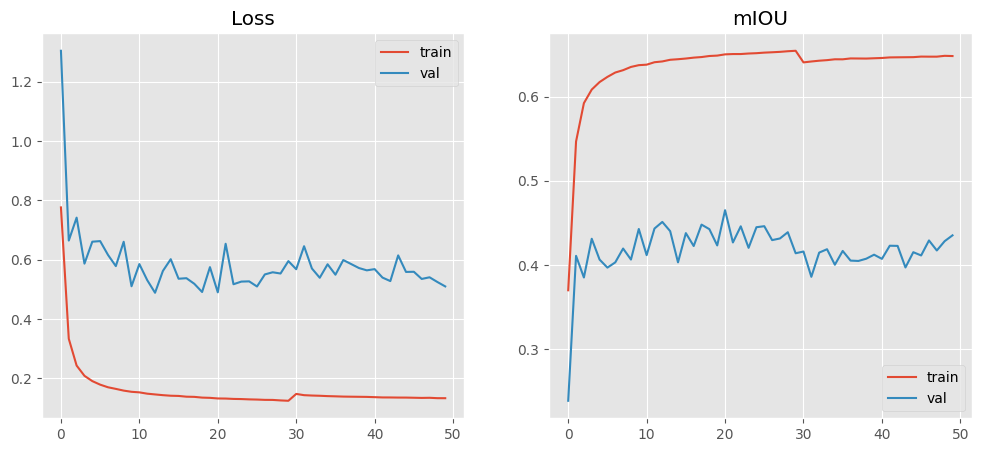

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(valid_loss, label="val")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("mIOU")
plt.plot(train_miou, label="train")
plt.plot(valid_miou, label="val")
plt.legend()

plt.show()

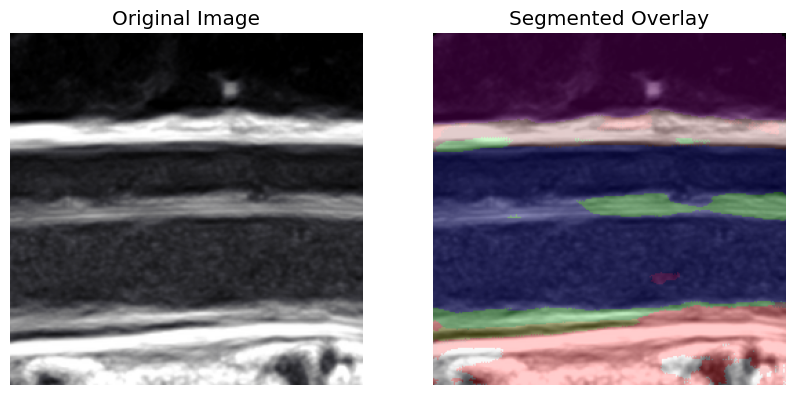

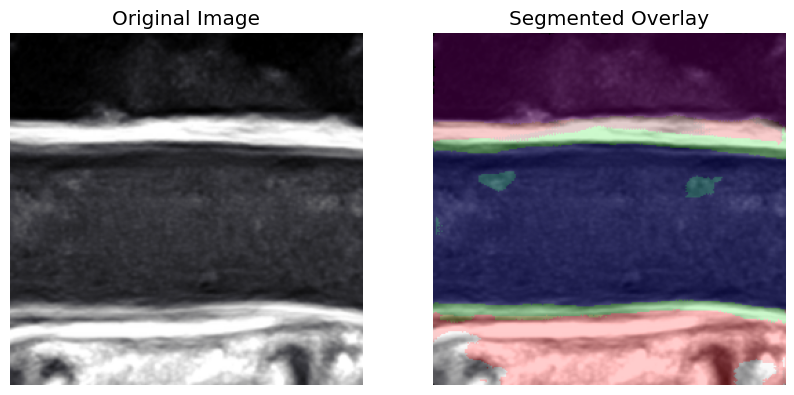

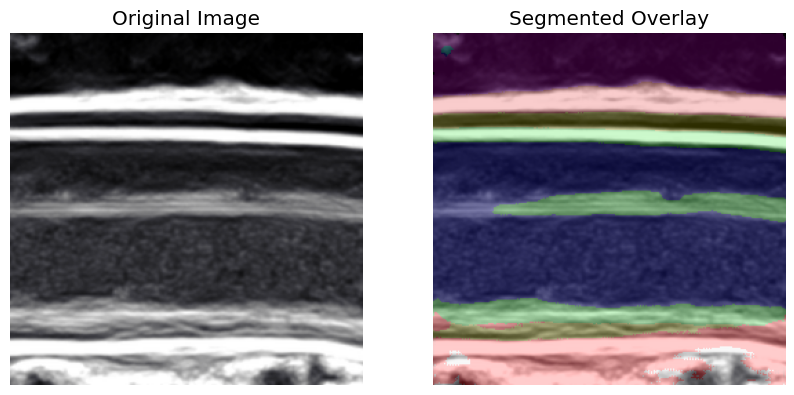

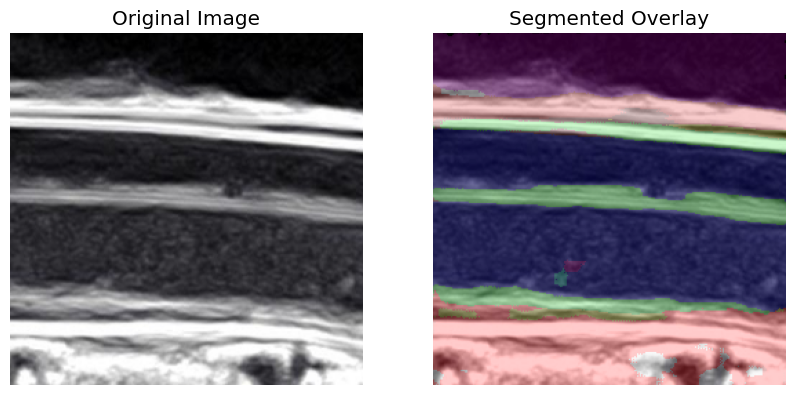

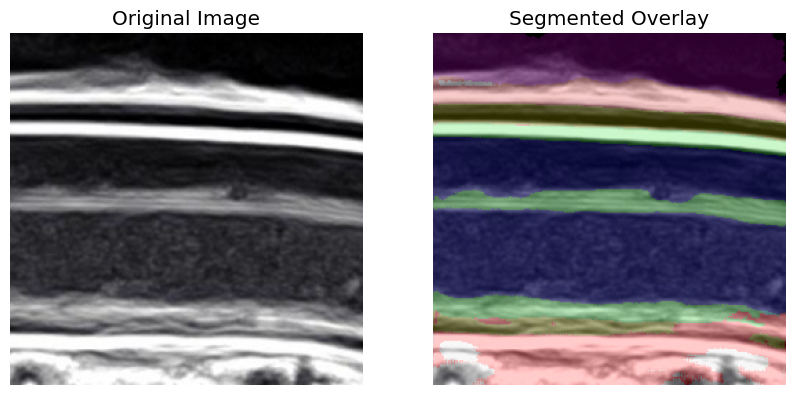

In [7]:
# Load the best model
best_model = UNet(num_classes=len(ALL_CLASSES)).to(device)
ckpt = torch.load(os.path.join(OUTPUT_PATH, 'best_model_iou.pth'), map_location=device)
best_model.load_state_dict(ckpt['model_state_dict'])
best_model.eval()

# Load test data
test_images, test_masks = get_test_images(root_path=DATA_PATH)

# Visualize first 5 images
for i in range(5):
    image_path = test_images[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Prepare for model
    image_tensor = torch.from_numpy(image_resized / 255.0).permute(2, 0, 1).float()

    # Get prediction
    outputs = get_segment_labels(image_tensor, best_model, device)
    segmented_map = draw_segmentation_map(outputs)

    # Create overlay
    final_image = image_overlay(image_resized, segmented_map)

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Overlay')
    plt.axis('off')
    plt.show()

In [10]:
import os
import zipfile
import shutil

# --- Configuration ---
# List of files and directories to zip. Paths are relative to the script's location (INSIDE Group_4).
items_to_zip = [
    'outputs',
    'SegmentationUNet',
    'running_code.ipynb'
]

# The output zip file will be created one level up.
output_zip_filename = '../Segmentation_Unet.zip' 

# --- Main Script Logic ---
print(f"Creating zip file: {output_zip_filename}")

try:
    with zipfile.ZipFile(output_zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for item in items_to_zip:
            if not os.path.exists(item):
                print(f"WARNING: Item not found, skipping: {item}")
                continue

            if os.path.isdir(item):
                print(f"Adding directory: {item}")
                # For a directory, we walk it. The archive name will be the directory name itself.
                for root, dirs, files in os.walk(item):
                    for file in files:
                        file_path = os.path.join(root, file)
                        # The archive name is the path relative to the current directory
                        archive_name = os.path.relpath(file_path, '.')
                        zipf.write(file_path, arcname=archive_name)
            else: # It's a file
                print(f"Adding file: {item}")
                # The archive name is just the filename
                archive_name = os.path.basename(item)
                zipf.write(item, arcname=archive_name)

    print("-" * 20)
    print(f"Successfully created {output_zip_filename}")
    print(f"Total size: {os.path.getsize(output_zip_filename) / (1024*1024):.2f} MB")

except Exception as e:
    print(f"An error occurred: {e}")

Creating zip file: ../Segmentation_Unet.zip
Adding directory: outputs
Adding directory: SegmentationUNet
Adding file: running_code.ipynb
--------------------
Successfully created ../Segmentation_Unet.zip
Total size: 221.53 MB


In [9]:
!ls

 SegmentationUNet	 running_code.ipynb	     unet_env
 Segmentation_Unet.zip	'segmentation dataset'	     unzip.py
 outputs		'segmentation dataset.zip'
